<a href="https://colab.research.google.com/github/jihyeon602/ETRI_lifelog_dataset/blob/main/ETRI_%EB%B2%A0%EC%9D%B4%EC%8A%A4%EB%9D%BC%EC%9D%B8%ED%95%98%EB%A3%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 기본 경로지정, parquet 파일 확인

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 1. 실험 재현을 위한 Seed 고정 (가장 맨 위에 둬야 함)
import os
import random
import numpy as np
import tensorflow as tf

os.environ['PYTHONHASHSEED'] = '42'
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
tf.config.experimental.enable_op_determinism()  # TensorFlow 2.9 이상에서만

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import random

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, ReLU, GlobalAveragePooling1D, Dense, Dropout

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from scipy.stats import mode
from scipy import stats
from datetime import timedelta
from tqdm import tqdm

# Note: Set the file path associated with the dataset.
challenge2025_dataset_path = '/content/drive/MyDrive/Sleep/ch2025_data_items'

# To print the list of data items
print("challenge 2025 dataset " + "="*5,'\n')
for file_name in sorted(os.listdir(challenge2025_dataset_path)):
    if file_name.endswith('.parquet'):
        print(file_name)

challenge 2025 dataset ===== 

ch2025_mACStatus.parquet
ch2025_mActivity.parquet
ch2025_mAmbience.parquet
ch2025_mBle.parquet
ch2025_mGps.parquet
ch2025_mLight.parquet
ch2025_mScreenStatus.parquet
ch2025_mUsageStats.parquet
ch2025_mWifi.parquet
ch2025_wHr.parquet
ch2025_wLight.parquet
ch2025_wPedo.parquet


# 데이터 전처리

### 1. mACStatus, 하루단위

In [3]:
# 1. 파일 경로
data_item = "mACStatus"
input1 = pd.read_parquet(os.path.join(challenge2025_dataset_path, f"ch2025_{data_item}.parquet"))

# 2. 하루 단위로 집계하는 함수 정의
def process_mACStatus(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date
    df = df.sort_values(['subject_id', 'timestamp'])

    results = []

    for (subj, date), group in df.groupby(['subject_id', 'date']):
        status = group['m_charging'].values  # 0/1 충전 상태
        times = group['timestamp'].values

        # 충전 비율
        ratio_charging = status.mean()

        # 충전/비충전 상태 전환 횟수
        transitions = (status[1:] != status[:-1]).sum()

        # 연속된 충전 상태(1)의 길이 측정
        lengths = []
        current_len = 0
        for val in status:
            if val == 1:
                current_len += 1
            elif current_len > 0:
                lengths.append(current_len)
                current_len = 0
        if current_len > 0:
            lengths.append(current_len)

        avg_charging_duration = np.mean(lengths) if lengths else 0
        max_charging_duration = np.max(lengths) if lengths else 0

        results.append({
            'subject_id': subj,
            'date': date,
            'charging_ratio': ratio_charging,
            'charging_transitions': transitions,
            'avg_charging_duration': avg_charging_duration,
            'max_charging_duration': max_charging_duration,
        })

    return pd.DataFrame(results)

# 3. 변환 실행
input1_daily = process_mACStatus(input1)


In [4]:
input1_daily.head()

,subject_id,date,charging_ratio,charging_transitions,avg_charging_duration,max_charging_duration
0,id01,2024-06-26,0.215859,22,13.363636,41
1,id01,2024-06-27,0.158571,32,13.875000,65
2,id01,2024-06-28,0.180282,29,17.066667,76
3,id01,2024-06-29,0.286567,3,192.000000,328
4,id01,2024-06-30,0.144286,8,50.500000,91


### 2. mActivity,  하루단위

In [5]:
# 1. 파일 경로
data_item = "mActivity"  # 사용자 활동 상태
input2 = pd.read_parquet(os.path.join(challenge2025_dataset_path, f"ch2025_{data_item}.parquet"))

# 2. 하루 단위로 집계하는 함수 정의
def process_mActivity_ratio(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date

    summary = []

    for (subj, date), group in df.groupby(['subject_id', 'date']):
        counts = group['m_activity'].value_counts(normalize=True)
        row = {'subject_id': subj, 'date': date}

        # 0~8 비율 저장
        for i in range(9):
            row[f'activity_{i}_ratio'] = counts.get(i, 0)

        # 주요 활동 정보
        row['dominant_activity'] = group['m_activity'].mode()[0]
        row['num_unique_activities'] = group['m_activity'].nunique()

        summary.append(row)

    return pd.DataFrame(summary)

# 3. 변환 실행
input2_daily = process_mActivity_ratio(input2)

In [6]:
input2_daily.head()

,subject_id,date,activity_0_ratio,activity_1_ratio,activity_2_ratio,activity_3_ratio,activity_4_ratio,activity_5_ratio,activity_6_ratio,activity_7_ratio,activity_8_ratio,dominant_activity,num_unique_activities
0,id01,2024-06-26,0.125176,0.001406,0,0.672293,0.157525,0,0,0.043601,0.0,3,5
1,id01,2024-06-27,0.146528,0.000000,0,0.611111,0.220833,0,0,0.021528,0.0,3,4
2,id01,2024-06-28,0.111806,0.000694,0,0.861806,0.000694,0,0,0.025000,0.0,3,5
3,id01,2024-06-29,0.065972,0.000000,0,0.916667,0.000000,0,0,0.017361,0.0,3,3
4,id01,2024-06-30,0.138194,0.000000,0,0.853472,0.000000,0,0,0.008333,0.0,3,3


In [10]:
(input2_daily == 0).sum()

,0
subject_id,0
date,0
activity_0_ratio,54
activity_1_ratio,453
activity_2_ratio,700
activity_3_ratio,5
activity_4_ratio,411
activity_5_ratio,700
activity_6_ratio,700
activity_7_ratio,36


In [11]:
# 2, 5, 6 열은 제거
input2_daily = input2_daily.drop(columns=['activity_2_ratio', 'activity_5_ratio', 'activity_6_ratio'])
print(input2_daily.head(2))

  subject_id        date  activity_0_ratio  activity_1_ratio  \
0       id01  2024-06-26          0.125176          0.001406   
1       id01  2024-06-27          0.146528          0.000000   

   activity_3_ratio  activity_4_ratio  activity_7_ratio  activity_8_ratio  \
0          0.672293          0.157525          0.043601               0.0   
1          0.611111          0.220833          0.021528               0.0   

   dominant_activity  num_unique_activities  
0                  3                      5  
1                  3                      4  


### 3. mAmbience, 하루단위

In [12]:
# 1. 파일 경로
data_item = "mAmbience"  # 주변 소음 데이터
input3 = pd.read_parquet(os.path.join(challenge2025_dataset_path, f"ch2025_{data_item}.parquet"))

# 2. Top-10 라벨 정의
top_10_labels = [
    "Inside, small room", "Speech", "Silence", "Music",
    "Narration, monologue", "Child speech, kid speaking",
    "Conversation", "Speech synthesizer", "Shout", "Babbling"
]

# 3. Top-10 라벨 추출 함수
def process_mAmbience_top10(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date

    for label in top_10_labels + ['others']:
        df[label] = 0.0

    for idx, row in df.iterrows():
        parsed = ast.literal_eval(row['m_ambience']) if isinstance(row['m_ambience'], str) else row['m_ambience']
        others_prob = 0.0
        for label, prob in parsed:
            prob = float(prob)
            if label in top_10_labels:
                df.at[idx, label] = prob
            else:
                others_prob += prob
        df.at[idx, 'others'] = others_prob

    return df.drop(columns=['m_ambience'])

# 4. 적용
input3 = process_mAmbience_top10(input3)

# 5. 하루 단위 요약
prob_cols = [col for col in input3.columns if col not in ['subject_id', 'timestamp', 'date']]
input3_daily = input3.groupby(['subject_id', 'date'])[prob_cols].mean().reset_index()


In [13]:
input3_daily.head()

,subject_id,date,"Inside, small room",Speech,Silence,Music,"Narration, monologue","Child speech, kid speaking",Conversation,Speech synthesizer,Shout,Babbling,others
0,id01,2024-06-26,2.183661e-02,2.466539e-01,0.116573,3.041167e-02,1.807150e-03,0.000645,0.000919,0.000033,0.000639,0.0,0.500729
1,id01,2024-06-27,5.669892e-05,8.622866e-08,0.998611,7.056701e-15,9.689560e-30,0.000000,0.000000,0.000000,0.000000,0.0,0.001542
2,id01,2024-06-28,1.019045e-05,1.434175e-03,0.995774,7.036657e-15,2.030282e-05,0.000002,0.000002,0.000005,0.000000,0.0,0.003555
3,id01,2024-06-29,3.832783e-04,8.622867e-08,0.998611,7.056701e-15,9.689562e-30,0.000000,0.000000,0.000000,0.000000,0.0,0.002089
4,id01,2024-06-30,2.072503e-27,8.622866e-08,0.998685,7.056702e-15,9.689561e-30,0.000000,0.000000,0.000000,0.000000,0.0,0.000934


In [14]:
(input3_daily == 0).sum()

,0
subject_id,0
date,0
"Inside, small room",0
Speech,0
Silence,0
Music,0
"Narration, monologue",0
"Child speech, kid speaking",413
Conversation,425
Speech synthesizer,463


### 4. mBLE, 하루단위
- 정규화 추가

In [15]:
data_item = "mBle"
input4 = pd.read_parquet(os.path.join(challenge2025_dataset_path, f"ch2025_{data_item}.parquet"))

def process_mBle(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date

    features = []

    for idx, row in df.iterrows():
        entry = ast.literal_eval(row['m_ble']) if isinstance(row['m_ble'], str) else row['m_ble']

        rssi_list = []
        class_0_cnt = 0  # 주로 헤드폰 스피커 등
        class_other_cnt = 0  # class 0 이외의 기기 수

        for device in entry:
            try:
                rssi = int(device['rssi'])
                rssi_list.append(rssi)

                if str(device['device_class']) == '0':
                    class_0_cnt += 1
                else:
                    class_other_cnt += 1
            except:
                continue  # malformed record

        feature = {
            'subject_id': row['subject_id'],
            'date': row['date'],
            'device_class_0_cnt': class_0_cnt,
            'device_class_others_cnt': class_other_cnt,
            'device_count': len(rssi_list),
            'rssi_mean': np.mean(rssi_list) if rssi_list else np.nan,
            'rssi_min': np.min(rssi_list) if rssi_list else np.nan,
            'rssi_max': np.max(rssi_list) if rssi_list else np.nan,
        }
        features.append(feature)

    return pd.DataFrame(features)

def summarize_mBle_daily(df):
    # row 단위 BLE feature 추출
    df = process_mBle(df)

    # 하루 단위 집계
    grouped = df.groupby(['subject_id', 'date']).agg({
        'device_class_0_cnt': 'sum',
        'device_class_others_cnt': 'sum',
        'rssi_mean': 'mean',
        'rssi_min': 'min',
        'rssi_max': 'max',
    }).reset_index()

    # 비율 계산
    total_cnt = grouped['device_class_0_cnt'] + grouped['device_class_others_cnt']
    grouped['device_class_0_ratio'] = grouped['device_class_0_cnt'] / total_cnt.replace(0, np.nan)
    grouped['device_class_others_ratio'] = grouped['device_class_others_cnt'] / total_cnt.replace(0, np.nan)

    # 원래 cnt 컬럼 제거
    grouped.drop(columns=['device_class_0_cnt', 'device_class_others_cnt'], inplace=True)

    # 정규화
    scale_cols = ['rssi_mean', 'rssi_min', 'rssi_max', 'device_class_0_ratio', 'device_class_others_ratio']
    scaler = StandardScaler()
    grouped[scale_cols] = scaler.fit_transform(grouped[scale_cols])

    return grouped

# ✅ 최종 결과 변수
input4_daily = summarize_mBle_daily(input4)

In [16]:
input4_daily.head()

,subject_id,date,rssi_mean,rssi_min,rssi_max,device_class_0_ratio,device_class_others_ratio
0,id01,2024-06-26,0.253524,0.977585,0.458037,0.803195,-0.803195
1,id01,2024-06-27,0.676639,0.977585,-0.184004,0.808880,-0.808880
2,id01,2024-06-28,-0.060611,0.977585,-0.642605,0.863155,-0.863155
3,id01,2024-06-29,1.778027,1.309048,-0.092284,-0.051538,0.051538
4,id01,2024-06-30,0.454062,1.640510,-0.275724,0.602391,-0.602391


### 5. mGps

In [19]:
# 1. 파일 경로
data_item = "mGps"  # 위치 데이터
input5 = pd.read_parquet(os.path.join(challenge2025_dataset_path, f"ch2025_{data_item}.parquet"))

# 2. 전처리 함수 정의
def process_mGps(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date

    features = []

    for idx, row in df.iterrows():
        gps_list = ast.literal_eval(row['m_gps']) if isinstance(row['m_gps'], str) else row['m_gps']

        altitudes = []
        latitudes = []
        longitudes = []
        speeds = []

        for entry in gps_list:
            try:
                altitudes.append(float(entry['altitude']))
                latitudes.append(float(entry['latitude']))
                longitudes.append(float(entry['longitude']))
                speeds.append(float(entry['speed']))
            except:
                continue

        features.append({
            'subject_id': row['subject_id'],
            'date': row['date'],
            'altitude_mean': np.mean(altitudes) if altitudes else np.nan,
            'latitude_std': np.std(latitudes) if latitudes else np.nan,
            'longitude_std': np.std(longitudes) if longitudes else np.nan,
            'speed_mean': np.mean(speeds) if speeds else np.nan,
            'speed_max': np.max(speeds) if speeds else np.nan,
            'speed_std': np.std(speeds) if speeds else np.nan,
        })

    return pd.DataFrame(features)

# 3. 하루 단위 요약
input5 = process_mGps(input5)

input5_daily = input5.groupby(['subject_id', 'date']).agg({
    'altitude_mean': 'mean',
    'latitude_std': 'mean',
    'longitude_std': 'mean',
    'speed_mean': 'mean',
    'speed_max': 'max',
    'speed_std': 'mean'
}).reset_index()

# 4. 정규화 (Z-score)
scale_cols = ['altitude_mean', 'latitude_std', 'longitude_std', 'speed_mean', 'speed_max', 'speed_std']
scaler = StandardScaler()
input5_daily[scale_cols] = scaler.fit_transform(input5_daily[scale_cols])



In [20]:
input5_daily.head()

,subject_id,date,altitude_mean,latitude_std,longitude_std,speed_mean,speed_max,speed_std
0,id01,2024-06-26,-0.489962,-0.218566,-0.280732,-0.197985,0.054666,0.328735
1,id01,2024-06-27,-0.360778,-0.144351,-0.092093,0.173658,0.492666,1.140199
2,id01,2024-06-28,-0.434479,-0.179065,-0.170938,-0.064637,1.164687,0.660034
3,id01,2024-06-29,0.083730,-0.391130,-0.359186,-0.314181,0.203013,-0.016106
4,id01,2024-06-30,0.409041,-0.356755,-0.374062,-0.439602,0.346281,-0.331095


### 6. mLight

In [21]:
# 1. 파일 경로
data_item = "mLight"
input6 = pd.read_parquet(os.path.join(challenge2025_dataset_path, f"ch2025_{data_item}.parquet"))

# 2. 전처리 함수 정의
def process_mLight(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date
    df['hour'] = df['timestamp'].dt.hour
    df['is_night'] = df['hour'].apply(lambda h: h >= 22 or h < 6)

    daily = df.groupby(['subject_id', 'date']).agg(
        light_mean=('m_light', 'mean'),
        light_std=('m_light', 'std'),
        light_max=('m_light', 'max'),
        light_min=('m_light', 'min'),
        light_night_mean=('m_light', lambda x: x[df.loc[x.index, 'is_night']].mean()),
        light_day_mean=('m_light', lambda x: x[~df.loc[x.index, 'is_night']].mean()),
        light_night_ratio=('is_night', 'mean')
    ).reset_index()

    return daily

# 3. 적용
input6_daily = process_mLight(input6)

# 4. 정규화
scale_cols = ['light_mean', 'light_std', 'light_max', 'light_min',
              'light_night_mean', 'light_day_mean', 'light_night_ratio']
scaler = StandardScaler()
input6_daily[scale_cols] = scaler.fit_transform(input6_daily[scale_cols])

In [22]:
input6_daily.head()

,subject_id,date,light_mean,light_std,light_max,light_min,light_night_mean,light_day_mean,light_night_ratio
0,id01,2024-06-26,0.755913,-0.145884,-0.212472,-0.037823,5.248161,0.429676,-2.650714
1,id01,2024-06-27,0.616061,0.345757,0.228485,-0.037823,-0.115888,0.677268,0.110178
2,id01,2024-06-28,0.129435,-0.219220,-0.214921,-0.037823,0.458452,0.132916,0.110178
3,id01,2024-06-29,-0.421503,-0.191303,-0.136546,-0.037823,-1.024313,-0.387634,0.110178
4,id01,2024-06-30,-0.389197,-0.197615,-0.174556,-0.037823,-0.571523,-0.373531,0.110178


### 7. mScreenStatus

In [23]:
# 1. 파일 경로
data_item = "mScreenStatus"
input7 = pd.read_parquet(os.path.join(challenge2025_dataset_path, f"ch2025_{data_item}.parquet"))

# 2. 통계 기반 처리 함수 정의
def process_mScreenStatus(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date

    features = []

    for (subj, date), group in df.groupby(['subject_id', 'date']):
        status = group['m_screen_use'].values
        ratio_on = status.mean()
        transitions = (status[1:] != status[:-1]).sum()

        durations = []
        current = 0
        for val in status:
            if val == 1:
                current += 1
            elif current > 0:
                durations.append(current)
                current = 0
        if current > 0:
            durations.append(current)

        features.append({
            'subject_id': subj,
            'date': date,
            'screen_on_ratio': ratio_on,
            'screen_on_transitions': transitions,
            'screen_on_duration_avg': np.mean(durations) if durations else 0,
            'screen_on_duration_max': np.max(durations) if durations else 0,
        })

    return pd.DataFrame(features)

# 3. 적용
input7_daily = process_mScreenStatus(input7)

# 4. 정규화
scale_cols = ['screen_on_ratio', 'screen_on_transitions', 'screen_on_duration_avg', 'screen_on_duration_max']
scaler = StandardScaler()
input7_daily[scale_cols] = scaler.fit_transform(input7_daily[scale_cols])

In [27]:
input7_daily.head()

,subject_id,date,screen_on_ratio,screen_on_transitions,screen_on_duration_avg,screen_on_duration_max
0,id01,2024-06-26,0.607561,-0.549021,-0.348796,-0.024523
1,id01,2024-06-27,1.251886,0.548349,0.232768,0.387294
2,id01,2024-06-28,0.830586,0.861884,-0.078814,-0.219595
3,id01,2024-06-29,0.081105,-0.078720,-0.078578,0.452318
4,id01,2024-06-30,-0.078518,0.548349,-0.365575,0.170548


### 8. mUsageStats

In [28]:
# 1. 파일 경로
data_item = "mUsageStats"
input8 = pd.read_parquet(os.path.join(challenge2025_dataset_path, f"ch2025_{data_item}.parquet"))

# 2. Top 앱 목록
top_apps = [
    'One UI 홈', '카카오톡', '시스템 UI', 'NAVER', '캐시워크', '성경일독Q',
    'YouTube', '통화', '메시지', '타임스프레드', 'Instagram'
]

# 3. 처리 함수 정의
def process_mUsageStats_v3(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date

    features = []

    for (subj, date), group in df.groupby(['subject_id', 'date']):
        top10_time = 0
        others_time = 0

        for row in group['m_usage_stats']:
            parsed = ast.literal_eval(row) if isinstance(row, str) else row
            for entry in parsed:
                app = entry.get('app_name')
                time = entry.get('total_time', 0)
                if app in top_apps:
                    top10_time += int(time)
                else:
                    others_time += int(time)

        total_time = top10_time + others_time

        feature = {
            'subject_id': subj,
            'date': date,
            'top10_apps_time': top10_time,
            'other_apps_time': others_time,
            'total_apps_time': total_time,
            'top10_apps_ratio': top10_time / total_time if total_time > 0 else np.nan,
            'other_apps_ratio': others_time / total_time if total_time > 0 else np.nan
        }
        features.append(feature)

    return pd.DataFrame(features)

# 4. 적용
input8_daily = process_mUsageStats_v3(input8)

# 5. 정규화
scale_cols = ['top10_apps_time', 'other_apps_time', 'total_apps_time', 'top10_apps_ratio', 'other_apps_ratio']
scaler = StandardScaler()
input8_daily[scale_cols] = scaler.fit_transform(input8_daily[scale_cols])


In [29]:
input8_daily.head()

,subject_id,date,top10_apps_time,other_apps_time,total_apps_time,top10_apps_ratio,other_apps_ratio
0,id01,2024-06-26,-1.050830,0.612684,-0.423030,-1.235826,1.235826
1,id01,2024-06-27,0.691206,2.405393,2.071946,-0.832303,0.832303
2,id01,2024-06-28,0.403535,1.515629,1.280734,-0.640426,0.640426
3,id01,2024-06-29,-0.732690,1.108947,0.140470,-1.187248,1.187248
4,id01,2024-06-30,-0.087494,2.297266,1.399432,-1.191263,1.191263


### 9. mWifi, 10분당 1회

In [30]:
# 1. 파일 경로
data_item = "mWifi"
input9 = pd.read_parquet(os.path.join(challenge2025_dataset_path, f"ch2025_{data_item}.parquet"))

# 2. 처리 함수 정의
def process_mWifi(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date

    results = []

    for (subj, date), group in df.groupby(['subject_id', 'date']):
        rssi_all = []

        for row in group['m_wifi']:
            parsed = ast.literal_eval(row) if isinstance(row, str) else row
            for ap in parsed:
                try:
                    rssi = int(ap['rssi'])
                    rssi_all.append(rssi)
                except:
                    continue

        results.append({
            'subject_id': subj,
            'date': date,
            'wifi_rssi_mean': np.mean(rssi_all) if rssi_all else np.nan,
            'wifi_rssi_min': np.min(rssi_all) if rssi_all else np.nan,
            'wifi_rssi_max': np.max(rssi_all) if rssi_all else np.nan,
            'wifi_detected_cnt': len(rssi_all)
        })

    return pd.DataFrame(results)

# 3. 적용 및 정규화
input9_daily = process_mWifi(input9)

scale_cols = ['wifi_rssi_mean', 'wifi_rssi_min', 'wifi_rssi_max', 'wifi_detected_cnt']
scaler = StandardScaler()
input9_daily[scale_cols] = scaler.fit_transform(input9_daily[scale_cols])

In [31]:
input9_daily.head()

,subject_id,date,wifi_rssi_mean,wifi_rssi_min,wifi_rssi_max,wifi_detected_cnt
0,id01,2024-06-26,0.479298,0.854573,0.678667,-0.861044
1,id01,2024-06-27,0.719656,0.530262,0.005197,-0.681544
2,id01,2024-06-28,0.713056,0.530262,0.005197,-0.728579
3,id01,2024-06-29,0.989650,0.854573,0.197617,-0.479007
4,id01,2024-06-30,0.881454,1.178885,0.293827,-0.697862


### 10. wHr

In [32]:
# Step 1
data_item = "wHr"
input10 = pd.read_parquet(os.path.join(challenge2025_dataset_path, f"ch2025_{data_item}.parquet"))

# Step 2
def get_time_block(hour):
    if 0 <= hour < 6:
        return 'early_morning'
    elif 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 18:
        return 'afternoon'
    else:
        return 'evening'

def process_wHr_by_timeblock(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date
    df['block'] = df['timestamp'].dt.hour.map(get_time_block)

    results = []

    for (subj, date), group in df.groupby(['subject_id', 'date']):
        block_stats = {'subject_id': subj, 'date': date}

        for block, block_group in group.groupby('block'):
            hr_all = []
            for row in block_group['heart_rate']:
                parsed = ast.literal_eval(row) if isinstance(row, str) else row
                hr_all.extend([int(h) for h in parsed if h is not None])

            if not hr_all:
                continue

            above_100 = [hr for hr in hr_all if hr > 100]
            block_stats[f'hr_{block}_mean'] = np.mean(hr_all)
            block_stats[f'hr_{block}_std'] = np.std(hr_all)
            block_stats[f'hr_{block}_max'] = np.max(hr_all)
            block_stats[f'hr_{block}_min'] = np.min(hr_all)
            block_stats[f'hr_{block}_above_100_ratio'] = len(above_100) / len(hr_all)

        results.append(block_stats)

    return pd.DataFrame(results)

# Step 3: 적용
input10_daily = process_wHr_by_timeblock(input10)

# Step 4: 정규화
from sklearn.preprocessing import StandardScaler
scale_cols = [col for col in input10_daily.columns if col not in ['subject_id', 'date']]
scaler = StandardScaler()
input10_daily[scale_cols] = scaler.fit_transform(input10_daily[scale_cols])

In [33]:
input10_daily.head()

,subject_id,date,hr_afternoon_mean,hr_afternoon_std,hr_afternoon_max,hr_afternoon_min,hr_afternoon_above_100_ratio,hr_evening_mean,hr_evening_std,hr_evening_max,...,hr_early_morning_mean,hr_early_morning_std,hr_early_morning_max,hr_early_morning_min,hr_early_morning_above_100_ratio,hr_morning_mean,hr_morning_std,hr_morning_max,hr_morning_min,hr_morning_above_100_ratio
0,id01,2024-06-26,-0.791794,0.321949,0.494505,0.182998,-0.634252,-0.662040,-0.286212,-0.356232,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,id01,2024-06-27,-0.084928,0.224402,-0.515707,0.512065,-0.097606,-0.577689,-0.143118,-0.456008,...,-0.048112,0.360117,-0.028820,-0.036297,-0.267925,-1.304508,-0.317083,-0.054185,-0.378948,-0.835893
2,id01,2024-06-28,-0.536624,0.279428,0.078536,-0.146068,-0.517898,-1.196885,-0.523234,-1.104545,...,0.153741,0.214474,0.281442,0.086821,-0.134497,-0.757596,0.168247,-0.564939,-0.514118,-0.596864
3,id01,2024-06-29,-3.623973,-3.073545,-4.734830,-0.392868,-1.040134,0.242061,-0.879564,-1.503646,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,id01,2024-06-30,0.086185,-0.673403,1.267021,0.347532,-0.434923,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.091613,-0.199253,0.047966,0.161730,-0.215968


### 11. wLight

In [34]:
# 1. 파일 경로
data_item = "wLight"
input11 = pd.read_parquet(os.path.join(challenge2025_dataset_path, f"ch2025_{data_item}.parquet"))

# 2. 시간 블록 함수 정의
def get_time_block(hour):
    if 0 <= hour < 6:
        return 'early_morning'
    elif 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 18:
        return 'afternoon'
    else:
        return 'evening'

# 3. 시간대별 처리 함수 정의
def process_wLight_by_timeblock(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date
    df['block'] = df['timestamp'].dt.hour.map(get_time_block)

    results = []

    for (subj, date), group in df.groupby(['subject_id', 'date']):
        block_stats = {'subject_id': subj, 'date': date}

        for block, block_group in group.groupby('block'):
            lux = block_group['w_light'].dropna().values
            if len(lux) == 0:
                continue

            block_stats[f'wlight_{block}_mean'] = np.mean(lux)
            block_stats[f'wlight_{block}_std'] = np.std(lux)
            block_stats[f'wlight_{block}_max'] = np.max(lux)
            block_stats[f'wlight_{block}_min'] = np.min(lux)

        results.append(block_stats)

    return pd.DataFrame(results)

# 4. 적용
input11_daily = process_wLight_by_timeblock(input11)

# 5. 정규화
scale_cols = [col for col in input11_daily.columns if col not in ['subject_id', 'date']]
scaler = StandardScaler()
input11_daily[scale_cols] = scaler.fit_transform(input11_daily[scale_cols])


In [35]:
input11_daily.head()

,subject_id,date,wlight_afternoon_mean,wlight_afternoon_std,wlight_afternoon_max,wlight_afternoon_min,wlight_evening_mean,wlight_evening_std,wlight_evening_max,wlight_evening_min,wlight_early_morning_mean,wlight_early_morning_std,wlight_early_morning_max,wlight_early_morning_min,wlight_morning_mean,wlight_morning_std,wlight_morning_max,wlight_morning_min
0,id01,2024-06-26,0.148823,0.320193,0.469390,-0.141704,0.380022,-0.095633,-0.335586,-0.072015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,id01,2024-06-27,0.462427,0.245720,-0.184010,-0.141704,0.508033,0.089114,-0.072229,-0.072015,0.574627,1.987219,1.776117,-0.085078,-0.068272,0.087126,0.100910,-0.13185
2,id01,2024-06-28,0.290971,0.295241,0.135470,-0.141704,-0.123845,-0.040437,-0.163956,-0.072015,0.195401,1.444045,1.970266,-0.085078,0.850599,2.523928,4.512623,-0.13185
3,id01,2024-06-29,-0.707853,-0.614529,-0.603216,-0.141704,0.635640,0.113558,-0.307049,-0.072015,-0.485617,-0.612763,-0.604320,-0.085078,-0.534151,-0.554921,-0.590567,-0.13185
4,id01,2024-06-30,-0.189047,-0.243636,-0.338936,-0.141704,-0.477193,-0.213586,-0.311941,-0.072015,-0.485617,-0.612763,-0.604320,-0.085078,-0.374204,-0.451518,-0.539491,-0.13185


### 12. wPedo

In [38]:
# 1. 파일 경로
data_item = "wPedo"
input12 = pd.read_parquet(os.path.join(challenge2025_dataset_path, f"ch2025_{data_item}.parquet"))

# 2. 불필요한 열, 이상치 제거
input12 = input12.drop(columns=['running_step', 'walking_step'])
input12 = input12[input12['burned_calories'] <= 15]

# 3. 통계 요약 함수
def process_wPedo(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date

    summary = df.groupby(['subject_id', 'date']).agg({
        'step': 'sum',
        'step_frequency': 'mean',
        'distance': 'sum',
        'speed': ['mean', 'max'],
        'burned_calories': 'sum'
    }).reset_index()

    # 컬럼 이름 정리
    summary.columns = ['subject_id', 'date',
                       'step_sum', 'step_frequency_mean',
                       'distance_sum', 'speed_mean', 'speed_max',
                       'burned_calories_sum']
    return summary

# 4. 적용
input12_daily = process_wPedo(input12)

# 5. Z-score 정규화
from sklearn.preprocessing import StandardScaler
scale_cols = [col for col in input12_daily.columns if col not in ['subject_id', 'date']]
scaler = StandardScaler()
input12_daily[scale_cols] = scaler.fit_transform(input12_daily[scale_cols])


In [41]:
input12_daily.head()

,subject_id,date,step_sum,step_frequency_mean,distance_sum,speed_mean,speed_max,burned_calories_sum
0,id01,2024-06-26,-0.142052,0.758831,-0.089120,0.847384,0.151055,-0.049770
1,id01,2024-06-27,-0.319709,-0.515189,-0.282553,-0.483220,-0.291376,-0.557004
2,id01,2024-06-28,0.076117,-0.218192,0.133882,-0.170586,0.305612,-0.100872
3,id01,2024-06-29,-1.467420,-1.415105,-1.466292,-1.411288,-2.210455,-1.438757
4,id01,2024-06-30,-0.351301,-0.517229,-0.307721,-0.479358,-0.030183,-0.361023


# Train.csv, Input Data 구조 설정

In [42]:
# 1. 레이블 로딩
df_label = pd.read_csv("/content/drive/MyDrive/Sleep/ch2025_metrics_train.csv")
df_label['lifelog_date'] = pd.to_datetime(df_label['lifelog_date'])
df_label['sleep_date'] = pd.to_datetime(df_label['sleep_date'])

# 2. 데이터프레임 구성 (input1_daily ~ input12_daily가 미리 처리되어 있다고 가정)
input_dict = {
    'input1': input1_daily,
    'input2': input2_daily,
    'input3': input3_daily,
    'input4': input4_daily,
    'input5': input5_daily,
    'input6': input6_daily,
    'input7': input7_daily,
    'input8': input8_daily,
    'input9': input9_daily,
    'input10': input10_daily,
    'input11': input11_daily,
    'input12': input12_daily,
}

# 3. feature_structure 자동 생성 함수
def build_feature_structure(input_dict):
    return {
        name: [col for col in df.columns if col not in ['subject_id', 'date']]
        for name, df in input_dict.items()
    }

# 자동 생성된 feature 구조
feature_structure = build_feature_structure(input_dict)

# 4. 하루 단위 병합 함수 정의
def merge_input_daily(subject_id, lifelog_date, input_dict, feature_structure):
    date = pd.to_datetime(lifelog_date).date()
    merged = pd.DataFrame({'subject_id': [subject_id], 'date': [date]})

    for input_name, columns in feature_structure.items():
        df = input_dict[input_name]
        df = df[df['subject_id'] == subject_id].copy()

        if 'date' not in df.columns:
            raise ValueError(f"{input_name}에는 'date' 컬럼이 없습니다.")

        df = df[df['date'] == date]
        if df.empty:
            for col in columns:
                merged[col] = 0  # 또는 np.nan
        else:
            for col in columns:
                merged[col] = df.iloc[0][col]

    return merged

# Input 데이터 생성

In [80]:
# 시계열 길이 정의 (예: 7일 시계열)
SEQUENCE_LENGTH = 7

# X 시퀀스 생성
X_seq = []
y_target = []

for _, row in tqdm(df_label.iterrows(), total=len(df_label)):
    subject_id = row['subject_id']
    lifelog_date = pd.to_datetime(row['lifelog_date'])

    # 각 일자 기준 이전 N일치 벡터 수집
    seq = []
    for i in range(SEQUENCE_LENGTH):
        date = lifelog_date - pd.Timedelta(days=SEQUENCE_LENGTH - 1 - i)
        daily_feature = merge_input_daily(subject_id, date, input_dict, feature_structure)
        seq.append(daily_feature.drop(columns=['subject_id', 'date']).values[0])  # (features,)

    seq_array = np.stack(seq, axis=-1)  # shape: (features, time_steps)
    X_seq.append(seq_array)
    y_target.append(row[['Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']].values)

# NaN을 0으로
X_seq = np.nan_to_num(X_seq, nan=0.0, posinf=0.0, neginf=0.0)
X_tensor = torch.from_numpy(X_seq).unsqueeze(1).float()

# 텐서 변환
X_seq = np.stack(X_seq)                        # shape: (batch, features, time_steps)
X_tensor = np.expand_dims(X_seq, axis=1)       # shape: (batch, 1, features, time_steps)
y_target = np.stack(y_target)                  # shape: (batch, 6)

100%|██████████| 450/450 [02:21<00:00,  3.19it/s]


In [81]:
print(X_seq.shape)
print(X_tensor.shape)
print(y_target.shape)

(450, 94, 7)
(450, 1, 94, 7)
(450, 6)


# 정규화한 텐서 이미지

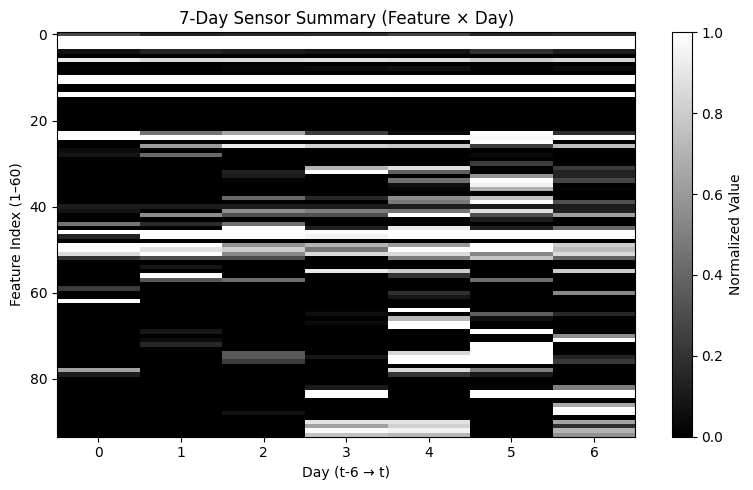

In [82]:
img_tensor = X_tensor[9, 0]  # shape: (94 features, 7 days)

plt.figure(figsize=(8, 5))
plt.imshow(img_tensor, aspect='auto', cmap='gray', vmin=0, vmax=1)
plt.title('7-Day Sensor Summary (Feature × Day)')
plt.xlabel('Day (t-6 → t)')
plt.ylabel('Feature Index (1–60)')
plt.colorbar(label='Normalized Value')
plt.tight_layout()
plt.show()

# (1) 스택 & 채널×시간 형태로 변환

In [83]:
# (1) 하루 단위 (7일 시퀀스) → (N, 94, 7)
X = np.stack(X_seq)                  # (N, 94, 7)
X_tensor = torch.from_numpy(X)      # (N, 94, 7)

# (2) CNN 입력용 채널 차원 추가: (N, 1, 94, 7)
X_tensor = X_tensor.unsqueeze(1).float()  # float32 변환 포함

# (3) y_target: (N, 6)
# object형 배열 → float형 배열로 변환
y_target = np.array(y_target, dtype=np.float32)

# 텐서 변환
y_tensor = torch.from_numpy(y_target).float()

# (2) Dataset & DataLoader

In [85]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 8

y_tensor = torch.from_numpy(y_target.astype(np.float32))

ds     = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(ds, batch_size=batch_size, shuffle=True, drop_last=True)

# 3) PixleepFlow (자동 feature‐map 크기 계산)

In [86]:
class PixleepFlowMultiHead(nn.Module):
    def __init__(self, in_ch=1, H=94, W=7):
        super().__init__()
        # CNN block: Conv → ReLU → MaxPool (2회 반복)
        self.features = nn.Sequential(
            nn.Conv2d(in_ch, 16, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),     nn.ReLU(), nn.MaxPool2d(2),
        )

        # Feature map 크기 계산 (H=94 → 23, W=7 → 1)
        feat_h, feat_w = H // 4, W // 4
        flat_dim = 32 * feat_h * feat_w

        # Shared FC
        self.shared_fc = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(128),
            nn.ReLU(),
        )

        # Binary tasks: Q1, Q2, Q3, S2, S3 → 5개 로짓
        self.head_bin = nn.Linear(128, 5)

        # Multi-class task: S1 → 3개 클래스 로짓
        self.head_s1 = nn.Linear(128, 3)

    def forward(self, x):
        x = self.features(x)
        x = self.shared_fc(x)
        out_bin = self.head_bin(x)
        out_s1 = self.head_s1(x)
        return out_bin, out_s1

In [88]:
print(torch.isnan(X_tensor).any())
print(torch.isinf(X_tensor).any())
print(torch.isnan(y_tensor).any())

tensor(False)
tensor(False)
tensor(False)


#(4) Train/Validation 분리

In [87]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

# 데이터 분할 (80% train / 20% valid)
X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# TensorDataset & DataLoader
batch_size = 8
train_ds = TensorDataset(X_train, y_train)
val_ds   = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

# (5) 손실/옵티마이저

In [89]:
import torch.optim as optim

bce = nn.BCEWithLogitsLoss()   # binary classification
ce  = nn.CrossEntropyLoss()    # multi-class classification

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = PixleepFlowMultiHead(in_ch=1, H=60, W=7).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# (6) 학습 루프

In [94]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()

        bin_logits, s1_logits = model(imgs)
        y_bin = torch.cat([labels[:, :3], labels[:, 4:6]], dim=1)
        y_s1  = labels[:, 3].long()

        loss_bin = bce(bin_logits, y_bin)
        loss_s1  = ce(s1_logits, y_s1)
        loss = loss_bin + loss_s1

        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_avg = train_loss / len(train_loader)

    # ---------------- Validation ----------------
    model.eval()
    val_loss = 0.0
    correct_bin = 0
    correct_s1  = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            bin_logits, s1_logits = model(imgs)
            y_bin = torch.cat([labels[:, :3], labels[:, 4:6]], dim=1)
            y_s1  = labels[:, 3].long()

            loss_bin = bce(bin_logits, y_bin)
            loss_s1  = ce(s1_logits, y_s1)
            loss = loss_bin + loss_s1
            val_loss += loss.item()

            # Binary Accuracy (Q1–Q3, S2–S3)
            bin_preds = torch.sigmoid(bin_logits) > 0.4
            correct_bin += (bin_preds == y_bin.bool()).sum().item()

            # Multi-class Accuracy (S1)
            s1_preds = torch.argmax(s1_logits, dim=1)
            correct_s1 += (s1_preds == y_s1).sum().item()

            total += y_bin.numel() + y_s1.size(0)

    val_avg = val_loss / len(val_loader)
    bin_acc = correct_bin / (len(val_ds) * 5)  # 5 binary targets
    s1_acc  = correct_s1 / len(val_ds)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_avg:.4f} | Val Loss: {val_avg:.4f} | "
          f"Bin Acc: {bin_acc:.3f} | S1 Acc: {s1_acc:.3f}")


Epoch 1/10 | Train Loss: 1.4814 | Val Loss: 1.7383 | Bin Acc: 0.598 | S1 Acc: 0.567
Epoch 2/10 | Train Loss: 1.4226 | Val Loss: 1.7352 | Bin Acc: 0.587 | S1 Acc: 0.544
Epoch 3/10 | Train Loss: 1.3894 | Val Loss: 1.7518 | Bin Acc: 0.576 | S1 Acc: 0.533
Epoch 4/10 | Train Loss: 1.3415 | Val Loss: 1.7399 | Bin Acc: 0.609 | S1 Acc: 0.544
Epoch 5/10 | Train Loss: 1.2559 | Val Loss: 1.8129 | Bin Acc: 0.629 | S1 Acc: 0.533
Epoch 6/10 | Train Loss: 1.1834 | Val Loss: 1.7546 | Bin Acc: 0.593 | S1 Acc: 0.589
Epoch 7/10 | Train Loss: 1.0847 | Val Loss: 1.8919 | Bin Acc: 0.607 | S1 Acc: 0.567
Epoch 8/10 | Train Loss: 1.0356 | Val Loss: 2.2385 | Bin Acc: 0.609 | S1 Acc: 0.567
Epoch 9/10 | Train Loss: 1.0017 | Val Loss: 2.1479 | Bin Acc: 0.602 | S1 Acc: 0.589
Epoch 10/10 | Train Loss: 0.9831 | Val Loss: 1.9175 | Bin Acc: 0.611 | S1 Acc: 0.500


In [95]:
torch.save(model.state_dict(), "pixleepflow_multih_head.pth")

# (7) ❗예시 예측 출력

In [96]:
model.eval()
with torch.no_grad():
    imgs, labels = next(iter(loader))
    imgs, labels = imgs.to(device), labels.to(device)

    bin_logits, s1_logits = model(imgs)  # (B,5), (B,3)
    bin_probs = torch.sigmoid(bin_logits)         # (B,5)
    s1_probs  = torch.softmax(s1_logits, dim=1)   # (B,3)

    bin_preds = (bin_probs >= 0.5).int()          # (B,5)
    s1_preds  = torch.argmax(s1_probs, dim=1)     # (B,)

    # 예시 출력 (i번째 샘플)
    i = 1
    y_true = labels[i].cpu().numpy()

    print("📌 Ground Truth")
    print(f"   Q1–Q3: {y_true[:3]} | S1: {y_true[3]} | S2–S3: {y_true[4:]}")

    print("\n🔹 Binary Task (Q1,Q2,Q3,S2,S3)")
    print(f"   Logits  : {bin_logits[i].cpu().numpy()}")
    print(f"   Probs   : {bin_probs[i].cpu().numpy()}")
    print(f"   Predict : {bin_preds[i].cpu().numpy()}")

    print("\n🔹 Multi-Class Task (S1)")
    print(f"   Logits  : {s1_logits[i].cpu().numpy()}")
    print(f"   Probs   : {s1_probs[i].cpu().numpy()}")
    print(f"   Predict : {s1_preds[i].item()}")


📌 Ground Truth
   Q1–Q3: [0. 0. 0.] | S1: 1.0 | S2–S3: [1. 0.]

🔹 Binary Task (Q1,Q2,Q3,S2,S3)
   Logits  : [-0.26306713 -0.05039418 -0.91845083  0.20019917  1.0719725 ]
   Probs   : [0.4346099  0.4874041  0.28527364 0.5498833  0.7449719 ]
   Predict : [0 0 0 1 1]

🔹 Multi-Class Task (S1)
   Logits  : [-0.33528382  0.11814206 -1.7300926 ]
   Probs   : [0.35441202 0.55773616 0.08785181]
   Predict : 1


# 제출 파일 생성

In [97]:
# 0) sample_submission 불러오기
df_sub = pd.read_csv(
    "/content/drive/MyDrive/Sleep/ch2025_submission_sample.csv",
    parse_dates=['lifelog_date', 'sleep_date']
)

# 1) 테스트 시퀀스 생성 (7일치 하루 요약)
SEQUENCE_LENGTH = 7
X_test_seq = []

for _, row in tqdm(df_sub.iterrows(), total=len(df_sub)):
    subject_id = row['subject_id']
    lifelog_date = pd.to_datetime(row['lifelog_date'])

    seq = []
    for i in range(SEQUENCE_LENGTH):
        date = lifelog_date - pd.Timedelta(days=SEQUENCE_LENGTH - 1 - i)
        daily_feature = merge_input_daily(subject_id, date, input_dict, feature_structure)
        seq.append(daily_feature.drop(columns=['subject_id', 'date']).values[0])

    seq_array = np.stack(seq, axis=-1)  # (features, 7일)
    X_test_seq.append(seq_array)

# 2) NumPy stack & tensor 변환
X_test_np = np.stack(X_test_seq)                      # (250, features, 7)
X_test_tensor = torch.from_numpy(X_test_np).unsqueeze(1).float()  # (250, 1, features, 7)
test_ds = TensorDataset(X_test_tensor)
test_loader = DataLoader(test_ds, batch_size=8, shuffle=False)

# 3) 모델 가중치 로드 & 추론
model.load_state_dict(torch.load("pixleepflow_multih_head.pth", map_location=device))
model.eval()
model.to(device)

all_bin_logits = []
all_s1_logits = []

with torch.no_grad():
    for (imgs,) in test_loader:
        imgs = imgs.to(device)
        bin_logits, s1_logits = model(imgs)  # (B,5), (B,3)
        all_bin_logits.append(bin_logits.cpu().numpy())
        all_s1_logits.append(s1_logits.cpu().numpy())

# 4) 후처리 및 예측 결과 저장
all_bin_logits = np.vstack(all_bin_logits)  # (250,5)
all_s1_logits = np.vstack(all_s1_logits)    # (250,3)

bin_probs = 1 / (1 + np.exp(-all_bin_logits))  # sigmoid 변환

df_sub['Q1'] = (bin_probs[:, 0] >= 0.4).astype(int)
df_sub['Q2'] = (bin_probs[:, 1] >= 0.4).astype(int)
df_sub['Q3'] = (bin_probs[:, 2] >= 0.4).astype(int)
df_sub['S1'] = np.argmax(all_s1_logits, axis=1)
df_sub['S2'] = (bin_probs[:, 3] >= 0.4).astype(int)
df_sub['S3'] = (bin_probs[:, 4] >= 0.4).astype(int)

# 5) 저장
out_path = "/content/drive/MyDrive/Sleep/submission_file/submission11.csv"
df_sub.to_csv(out_path, index=False)
print(f"▶ {out_path} 생성 완료")

100%|██████████| 250/250 [01:20<00:00,  3.10it/s]

▶ /content/drive/MyDrive/Sleep/submission_file/submission11.csv 생성 완료


In [93]:
df_sub.shape

(250, 9)